# 利用遗传算法（Geatpy库）调参——SVM鸢尾花分类
**姓名：邹子涵  
学号：202020085400139**

## 一、Geatpy数据结构
### 1、种群染色体Chrom
Geatpy中，种群染色体是一个ap.array类型的二维矩阵，一般用Chrom命名，每一行对应一个个体的一条染色体。  
我们一般把种群的规模(即种群的个体数)用Nind命名；把种群个体的染色体长度用Lind命名，则Chrom的结构如下所示：  
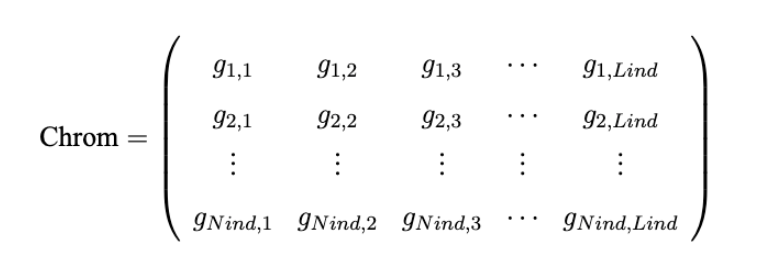  
### 2、种群表现型Phen
种群表现型的数据结构跟种群染色体基本一致，也是numpy的array类型。我们一般用Phen来命名。是种群染色体矩阵Chrom经过解码后得到的基因表现型矩阵，每一行对应一个个体，每一列对应一个决策变量。若用N var表示变量的个数，则种群表现型矩阵Phen的结构如下图：  
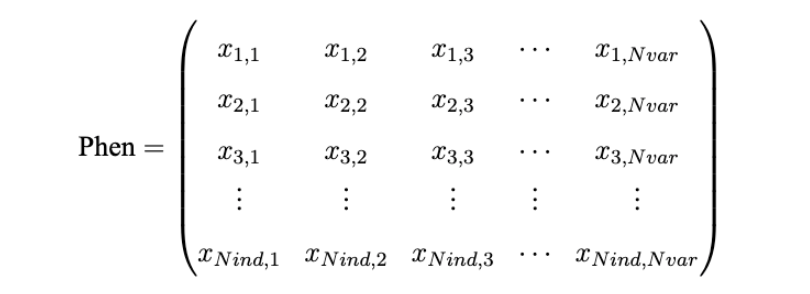  
### 3、目标函数Objv
目标函数是一个np.array，也就是每一个样本的分类结果的交叉验证得分。  
Geatpy采用np.array类型矩阵来存储种群的目标函数值。一般命名为ObjV，每一行对应每一个个体，因此它拥有与Chrom相同的行数；每一列对应一个目标函数。  
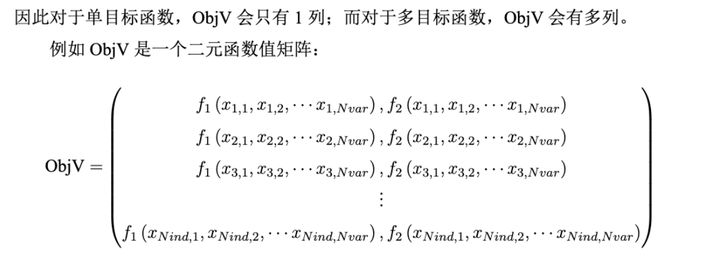  
### 4、个体适应度FitnV
Geatpy采用列向量来存储种群个体适应度。一般命名为F itnV，它同样是np.array类型，每一行对应种群矩阵的每一个个体。因此它拥有与Chrom相同的行数。  
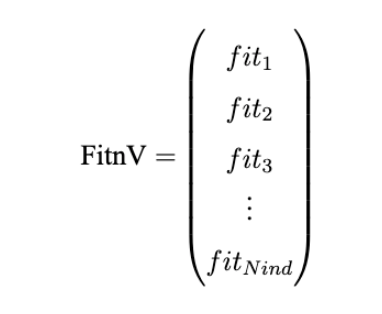  
### 5、违反约束程度CV
CV(Constraint Violation Value)来存储种群个踢违反各个约束条件的程度。一般命名为CV，它的每一行对应种群的每一个个体。每一列对应一个约束条件，因此若有一个约束条件。则CV矩阵的结构如下图所示：  
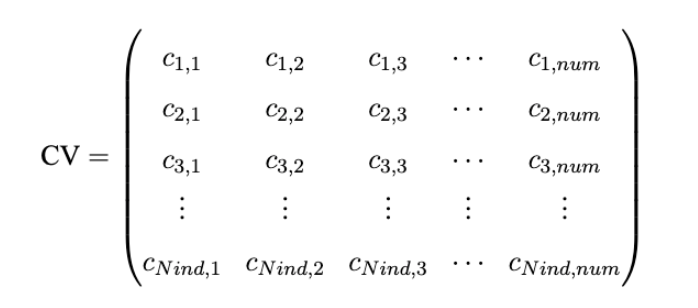  
CV矩阵的某个元素若小于或等于0，则表示该元素对应的个体满足对应的约束条件，也就是我们之前一直使用的"可行性法则"来定义约束条件。  
### 6、译码矩阵FiledV
Geatpy使用译码矩阵(俗称区域描述器)来描述种群染色体的特征，如染色体中的每一位元素所表达的决策变量的范围、是否包含范围的边界、采用二进制还是格雷码、是否使用对数刻度、染色体解码后所代表的决策变量的是连续型变量还是离散型变量等等。  
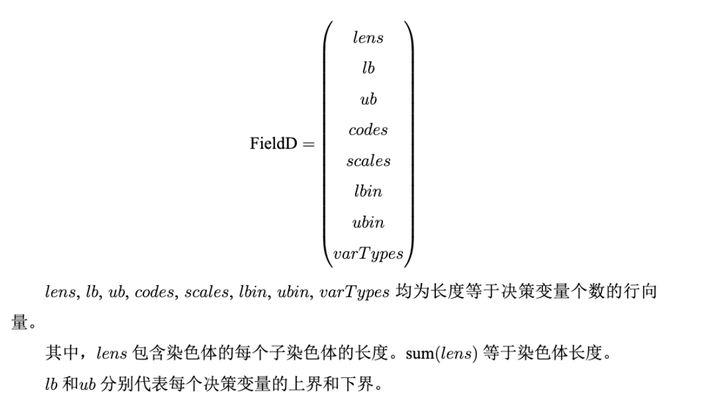  
### 7、进化追踪器trace
在使用Geatpy进行进化算法编程时，常常建立一个进化追踪器(如pop_trace)来记录种群在进化的过程中各代的最优个体。其中MAXGEN是种群进化的代数。trace的每一列代表不同的指标，比如第一列记录各代种群的最佳目标函数值，第二列记录各代种群的平均目标函数值......trace的每一行对应每一代，如第一行代表第一代，第二行代表第二代......以此类推。  
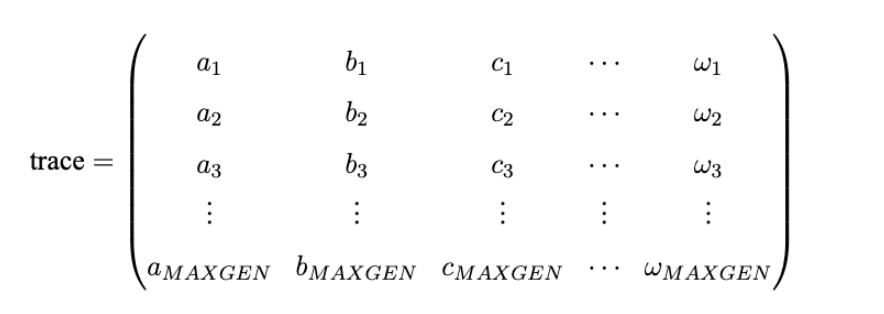  
### 8、population类
在Geatpy提供的面向对象进化算法框架中，种群类(Population)是一个存储着与种群个体相关信息的类。它有以下基本属性：  
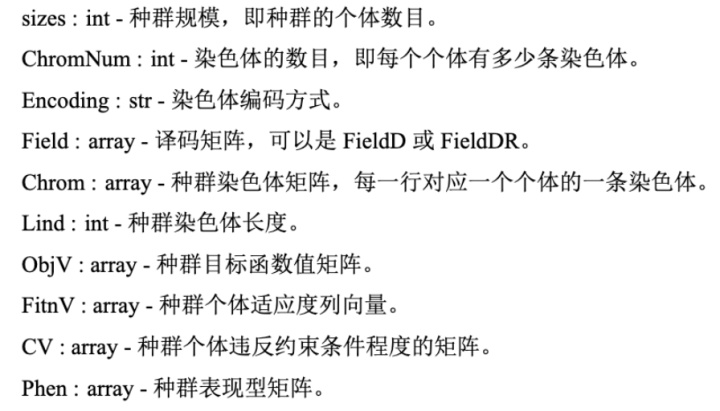

## 二、遗传算法调参SVM
### 1、iris鸢尾花分类数据集
鸢尾花数据集一个经典的分类问题数据集，[数据集](http://archive.ics.uci.edu/ml/datasets/Iris)长这样子，前4列是特征，最后一列是鸢尾花的分类target：

In [1]:
import pandas as pd

data = pd.read_csv("dataset/iris.data",header=None,names=['sepalLength','sepalWidth','petalLength','petalWidth','class'])
data

,sepalLength,sepalWidth,petalLength,petalWidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### 2、geatpy工作流程
我们之前单目标优化问题的解决办法的大概流程是：  
1. 随机初始化第一代种群的个体Phen;
2. 可行性约束CV;
3. 计算个体的适应度（可以理解为目标函数上的表现好坏）；
4. 选择、交叉、变异、进化
5. 得到最优种群的最优个体  
  
在机器学习自动化调参中也是类似的，这里主要需要理解的是**把每一次的模型训练（决策变量C和Gamma采用RI实整数编码）作为种群的一个个体！**  
1. 种群数量NIND = 50代表第一代种群先进行50次的模型训练作为50个初始个体，每次训练的[C，G]（当然每次训练的C和G还是随机初始化的）就是这个个体的的染色体；
2. 目标函数就是训练集上的分类准确度（当然下面代码用的交叉验证分数，含义其实是一样的）；3. 选择、交叉、变异、进化
4. 最后末代种群中的最优个体得到我们想要的C和Gamma，把这两个参数代入到测试集上计算测试集结果  

## 3、geatpy和sklearn.svm实例

In [2]:
import geatpy as ea
import numpy as np

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import cross_val_score

import multiprocessing as mp
from multiprocessing import Pool as ProcessPool
from multiprocessing.dummy import Pool as ThreadPool

print("geatpy版本:",ea.__version__)

geatpy版本: 2.6.0


In [3]:
class MyProblem(ea.Problem):
    def __init__(self,PoolType): # PoolType是取值为'Process'或'Thread'的字符串
        name = "MyProblem" # 初始化函数名name
        M = 1 # 初始化维数（目标维数——class）
        maxormins = [-1] # 初始化maxormin(目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = [0,0] # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [2**(-8)] * Dim # 决策变量下界
        ub = [2**8] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self,name,M,maxormins,Dim,varTypes,lb,ub,lbin,ubin)
        # 目标函数计算中用到的一些数据
        fp = open("dataset/iris_train.data")
        datas = []
        data_targets = []
        for line in fp.readlines():
            line_data = line.strip('\n').split(',')
            data = []
            for i in line_data[0:4]:
                data.append(float(i))
            datas.append(data)
            data_targets.append(line_data[4])
        fp.close()
        self.data = preprocessing.scale(np.array(datas)) # 训练集的特征数据（归一化）
        self.dataTarget = np.array(data_targets)
        # 设置用多线程还是多进程
        self.PoolType = PoolType
        if self.PoolType == 'Thread':
            self.pool = ThreadPool(2)
        elif self.PoolType == 'Process':
            num_cores = int(mp.cpu_count())
            self.pool = ProcessPool(num_cores)
            
    def aimFunc(self,pop): # 目标函数，采用多线程加速计算
        Vars = pop.Phen # 得到决策变量矩阵\
        args = list(zip(list(range(pop.sizes)), [Vars] * pop.sizes, [self.data] * pop.sizes, [self.dataTarget] * pop.sizes))
        if self.PoolType == 'Thread':
            pop.ObjV = np.array(list(self.pool.map(subAimFunc, args)))
        elif self.PoolType == 'Process':
            result = self.pool.map_async(subAimFunc,args)
            result.wait()
            pop.ObjV = np.array(result.get())
            
    def test(self,C,G): # 代入优化后的C、Gamma对测试集进行检验
        # 读取测试集数据
        fp = open("dataset/iris_test.data")
        datas = []
        data_targets = []
        for line in fp.readlines():
            line_data = line.strip('\n').split(',')
            data = []
            for i in line_data[0:4]:
                data.append(float(i))
            datas.append(data)
            data_targets.append(line_data[4])
        fp.close()
        data_test = preprocessing.scale(np.array(datas))  # 测试集的特征数据（归一化）
        dataTarget_test = np.array(data_targets)  # 测试集的标签数据
        svc = svm.SVC(C=C, kernel='rbf', gamma=G).fit(self.data, self.dataTarget)  # 创建分类器对象并用训练集的数据拟合分类器模型
        dataTarget_predict = svc.predict(data_test)  # 采用训练好的分类器对象对测试集数据进行预测
        print("测试集数据分类正确率 = %s%%" % (len(np.where(dataTarget_predict == dataTarget_test)[0]) / len(dataTarget_test) * 100))

In [4]:
def subAimFunc(args):
    i = args[0]
    Vars = args[1]
    data = args[2]
    dataTarget = args[3]
    C = Vars[i, 0]
    G = Vars[i, 1]
    svc = svm.SVC(C=C, kernel='rbf', gamma=G).fit(data, dataTarget)  # 创建分类器对象并用训练集的数据拟合分类器模型
    scores = cross_val_score(svc, data, dataTarget, cv=30)  # 计算交叉验证的得分
    ObjV_i = [scores.mean()]  # 把交叉验证的平均得分作为目标函数值
    return ObjV_i

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   50   | 8.88889E-01 | 8.88889E-01 | 5.39111E-01 | 4.11111E-01 | 1.30246E-01 
 1 |  100   | 9.44444E-01 | 9.44444E-01 | 5.98889E-01 | 4.11111E-01 | 1.64748E-01 
 2 |  150   | 9.55556E-01 | 9.55556E-01 | 6.73778E-01 | 4.11111E-01 | 1.86915E-01 
 3 |  200   | 9.55556E-01 | 9.55556E-01 | 7.28000E-01 | 4.11111E-01 | 1.74048E-01 
 4 |  250   | 9.55556E-01 | 9.55556E-01 | 8.12444E-01 | 4.55556E-01 | 1.52472E-01 
 5 |  300   | 9.66667E-01 | 9.66667E-01 | 8.72667E-01 | 6.11111E-01 | 1.14745E-01 
 6 |  350   | 9.66667E-01 | 9.66667E-01 | 9.09111E-01 | 6.11111E-01 | 8.04521E-02 
 7 |  400   | 9.66667E-01 | 9.66667E-01 | 9.28889E-01 | 6.44444E-01 | 5.23992E-02 
 8 |  450   | 9.77778E-01 | 9.77778E-01 | 9.41778E-01 | 6.44444E-01 | 4.51915E-02 
 9 |  500   | 9.77778E-01 | 9.77778E-01 | 9.50222E-01 | 8.66667E-01 | 1.47807E-02 
 10|

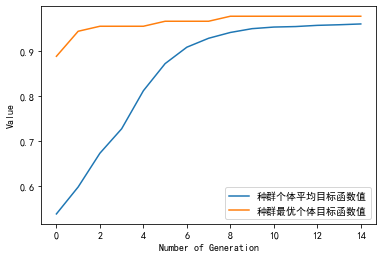

种群信息导出完毕。
评价次数：750
时间已过 34.8267502784729 秒
最优的目标函数值为：0.9777777777777777
最优的控制变量值为：
37.42862815409899
0.00390625
测试集数据分类正确率 = 96.66666666666667%


In [5]:
if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    PoolType = 'Thread'  # 设置采用多线程，若修改为: PoolType = 'Process'，则表示用多进程
    problem = MyProblem(PoolType)  # 生成问题对象
    """=================================种群设置=============================="""
    Encoding = 'RI'  # 编码方式
    NIND = 50  # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders)  # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND)  # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population)  # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 30  # 最大进化代数
    myAlgorithm.trappedValue = 1e-6  # “进化停滞”判断阈值
    myAlgorithm.maxTrappedCount = 10  # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
    myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
    myAlgorithm.verbose = True  # 设置是否打印输出日志信息
    myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）
    """==========================调用算法模板进行种群进化========================"""
    [BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
    BestIndi.save()  # 把最优个体的信息保存到文件中
    """=================================输出结果=============================="""
    print('评价次数：%s' % myAlgorithm.evalsNum)
    print('时间已过 %s 秒' % myAlgorithm.passTime)
    if BestIndi.sizes != 0:
        print('最优的目标函数值为：%s' % (BestIndi.ObjV[0][0]))
        print('最优的控制变量值为：')
        for i in range(BestIndi.Phen.shape[1]):
            print(BestIndi.Phen[0, i])
        """=================================检验结果==============================="""
        problem.test(C=BestIndi.Phen[0, 0], G=BestIndi.Phen[0, 1])
    else:
        print('没找到可行解。')

可以看到最优的C=37.4286,G=0.0039，此时训练集的分类正确率达到97.78%，训练好的模型在测试集的分类正确率是96.67%  
[参考内容——知乎](https://www.zhihu.com/search?type=content&q=geatpy)  
[github](https://github.com/geatpy-dev/geatpy/tree/master/geatpy/demo/soea_demo/soea_demo6)